danitsche

Steam Reviews Dataset 2021:
21+ million user reviews
300 different games
23 attributes

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as pn
import wordcloud
from plotnine import ggplot, aes, geom_line, labs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.metrics import classification_report, mean_squared_error



df = pd.read_csv("C:/Users/dn121/PythonVSCode/math385finalproject/steam_reviews.csv", nrows=3000000)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit='s', errors='coerce')
df['timestamp_updated'] = pd.to_datetime(df['timestamp_updated'], unit='s', errors='coerce')
df['review'] = df['review'].fillna('')

unique_games = df['app_name'].unique()
print("Total reviews: 3,000,000")
print(f"Total unique games: {len(unique_games)}")
print(unique_games)

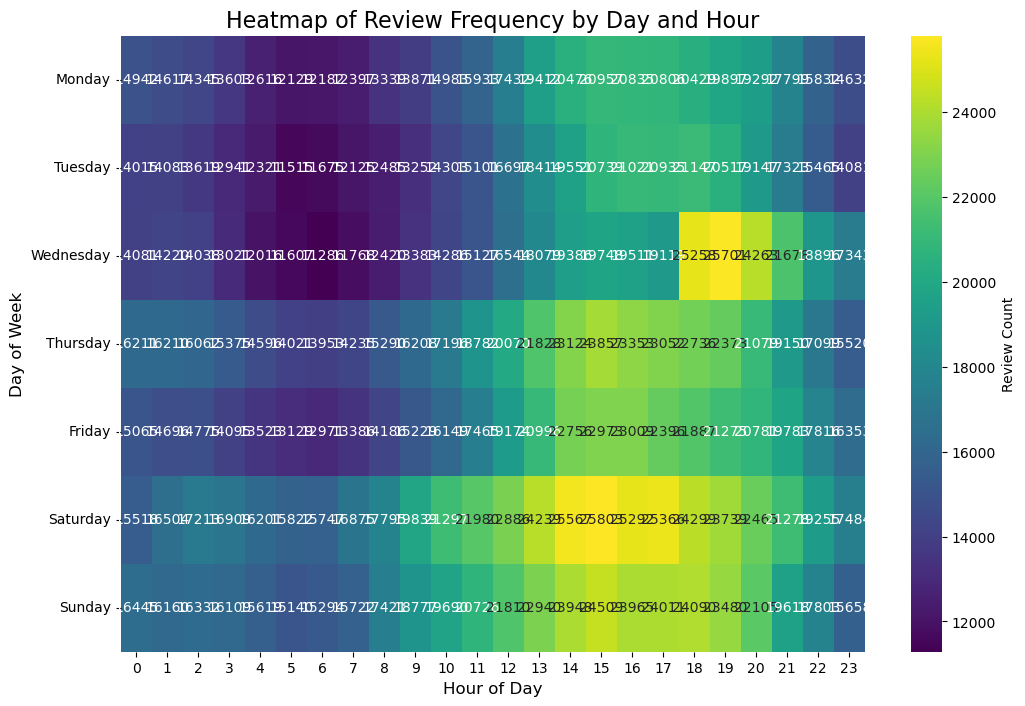

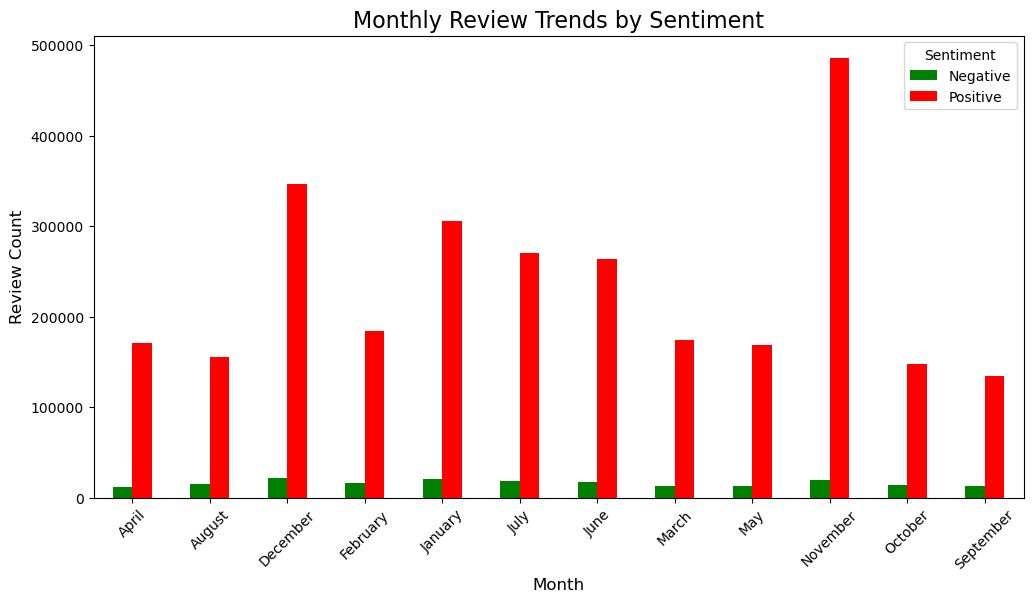

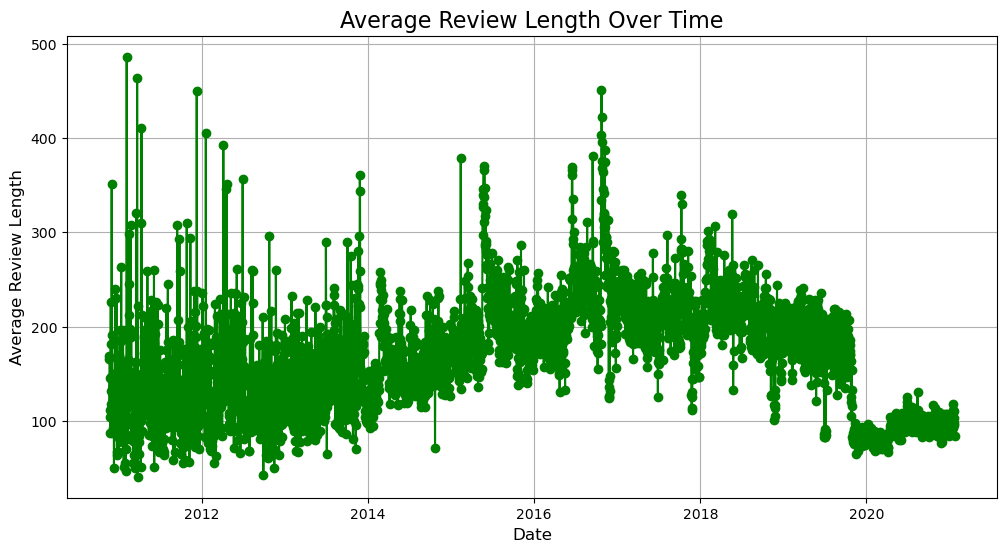

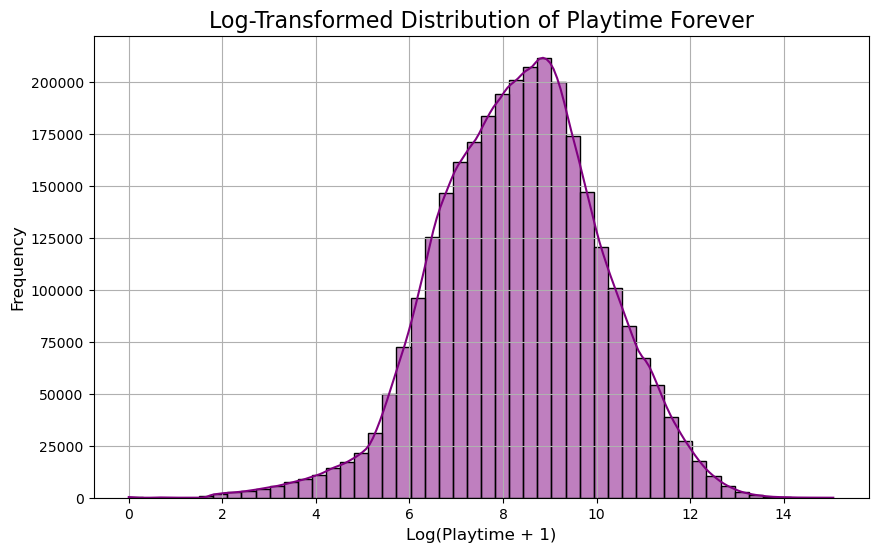

In [19]:
#new time columns for analysis
df['hour_created'] = df['timestamp_created'].dt.hour
df['day_of_week'] = df['timestamp_created'].dt.day_name()
df['sentiment'] = df['recommended'].apply(lambda x: 'Positive' if x else 'Negative')



heatmap_data = df.pivot_table(index='day_of_week', columns='hour_created', values='review_id', aggfunc='count').fillna(0)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(days_order)
hourly_sentiment = df.groupby(['hour_created', 'sentiment']).size().unstack(fill_value=0)
hourly_sentiment_melted = hourly_sentiment.reset_index().melt(id_vars=['hour_created'], var_name='sentiment', value_name='count')


plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="viridis", annot=True, fmt=".0f", cbar_kws={'label': 'Review Count'})
plt.title("Heatmap of Review Frequency by Day and Hour", fontsize=16)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Day of Week", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=0)
plt.show()


#extracting month and week of the year
df['month'] = df['timestamp_created'].dt.month_name()
df['week_of_year'] = df['timestamp_created'].dt.isocalendar().week

#group by month and sentiment
monthly_trends = df.groupby(['month', 'sentiment']).size().unstack(fill_value=0)

#plotting monthly trends
monthly_trends.plot(kind='bar', figsize=(12, 6), color=['green', 'red'])
plt.title("Monthly Review Trends by Sentiment", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Review Count", fontsize=12)
plt.legend(title="Sentiment")
plt.xticks(rotation=45)
plt.show()

#calculating review length
df['review_length'] = df['review'].str.len()
#clip reviews over 10,000 chars
df['review_length'] = df['review_length'].clip(upper=5000)


#group by date and calculate average review length
avg_review_length = df.groupby(df['timestamp_created'].dt.date)['review_length'].mean()

#plotting average review length over time
plt.figure(figsize=(12, 6))
avg_review_length.plot(marker='o', color='green')
plt.title("Average Review Length Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Review Length", fontsize=12)
plt.grid(True)
plt.show()


df['playtime_clipped'] = df['author.playtime_forever'].clip(upper=500)

#log-transform playtime
df['playtime_log'] = np.log1p(df['author.playtime_forever'])

#plot log-transformed distribution, as most playtimes are quite small
plt.figure(figsize=(10, 6))
sns.histplot(df['playtime_log'], bins=50, kde=True, color='purple')
plt.title("Log-Transformed Distribution of Playtime Forever", fontsize=16)
plt.xlabel("Log(Playtime + 1)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()






In [5]:
#predict whether a review is helpful if it has at least one helpful vote (binary target)
df['helpful'] = (df['votes_helpful'] > 0).astype(int)

#features and target
X = df[['author.playtime_forever', 'review_length']]
y = df['helpful']

#split of 20/80
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#training logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

#precision = proportion of correct positive predictions
#recall = proportion of actual postivie cases (review is helpful)
#f1-score harmonic mean of precision and recall
#support = numer of actual samples for each class( 0 or 1)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.99      0.84    437123
           1       0.58      0.04      0.08    162877

    accuracy                           0.73    600000
   macro avg       0.66      0.52      0.46    600000
weighted avg       0.69      0.73      0.64    600000



Metric	   Class 0 (Not Helpful)	Class 1 (Helpful)
Precision	0.74	0.58
Recall	    0.99	0.04
F1-Score	0.84	0.08

Model is biased towards class 0, as most reviews do not have votes.
73% accuracy reflects this bias as heavy

In [ ]:
from sklearn.preprocessing import StandardScaler

#predict number of helpful votes using playtime and review_length
#playtime is continious variable
df_sample = df.sample(n=10000, random_state=42)
X = df_sample[['author.playtime_forever', 'review_length', 'author.num_games_owned', 'author.num_reviews']]
y = df_sample['votes_helpful']

#training linear regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

#mse of linear model
y_pred = linear_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


#standardizing features so featuers contribute equally to the model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#training logistic regression
model = LogisticRegression(max_iter=500)
model.fit(X_scaled, y)

#feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(feature_importance)

Mean Squared Error: 0.1927510533300951
                   Feature  Coefficient
1            review_length    -0.430520
2   author.num_games_owned    -0.262377
0  author.playtime_forever     0.130241
3       author.num_reviews    -0.101007


Findings: 

MSE: Relatively small error between actual and predicted votes_helpful

review_length: Longer reviews are associated with lower likelihood of recieving helpful votes

num_games_owned: Users with larger libraries are less likely to write reviews with helpful votes

num_reviews: Users that write more reviews tend to receive fewer helpful votes for individual reviews

playtime_forever: More playtime increases likelihood of receiving helpful votes.



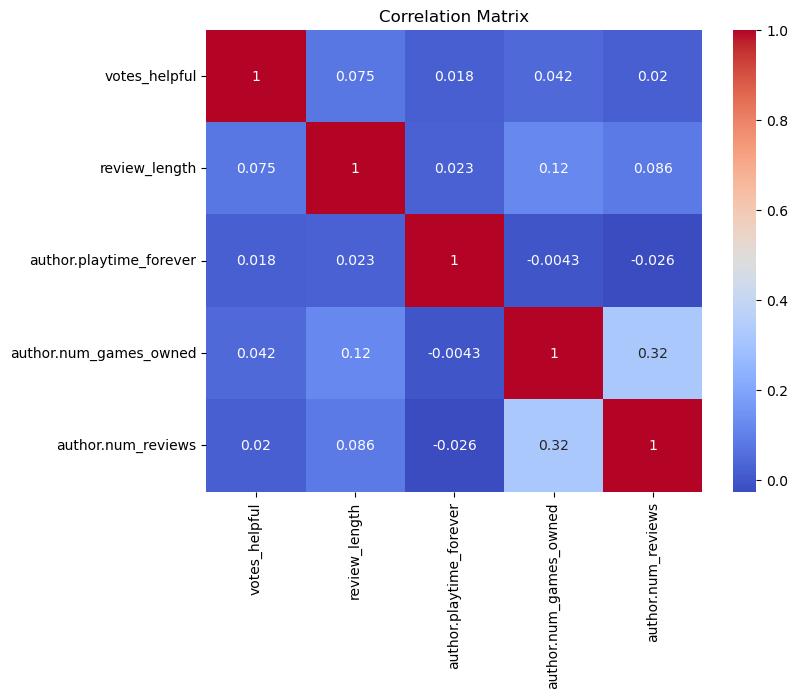

In [ ]:
correlation_data = df[['votes_helpful', 'review_length', 'author.playtime_forever', 
                       'author.num_games_owned', 'author.num_reviews']]

#correlation matrix
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


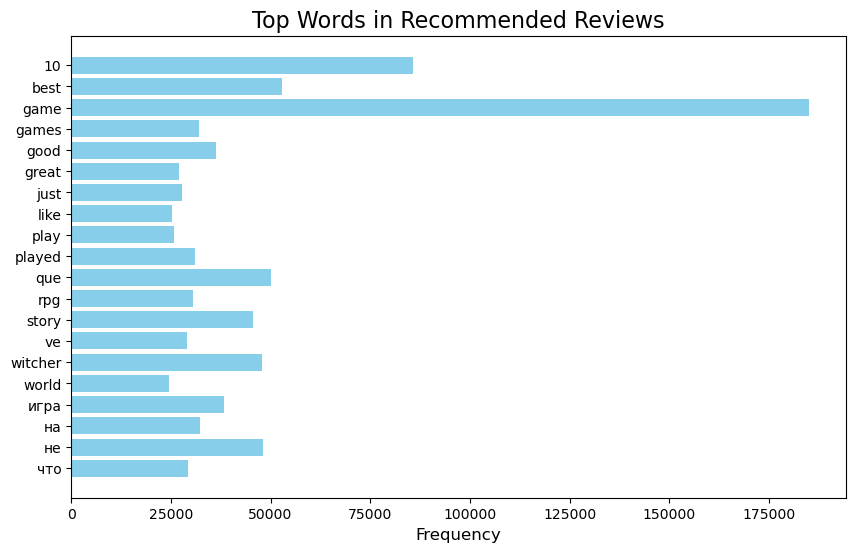

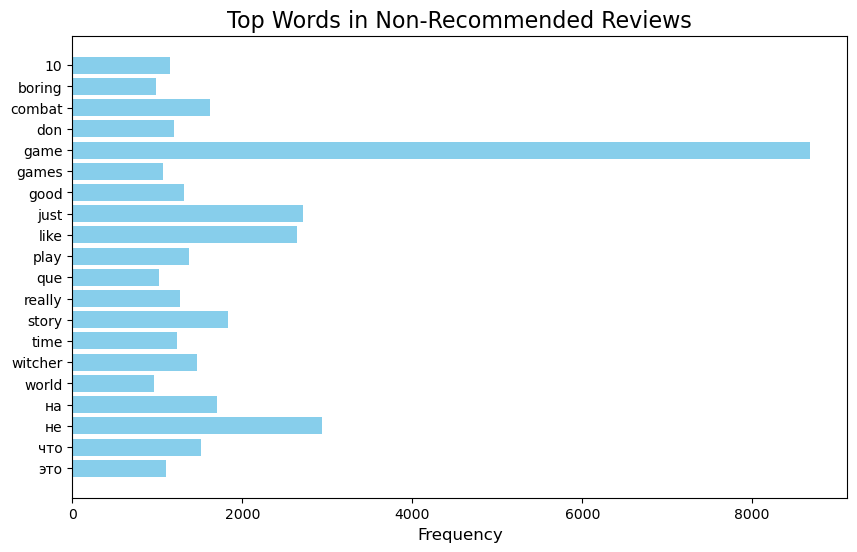

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


df_sample = pd.read_csv("C:/Users/dn121/PythonVSCode/math385finalproject/steam_reviews.csv", nrows=500000)

#recommended and non-recommended review samples
recommended_reviews = df_sample[df_sample['recommended']]['review'].dropna()
non_recommended_reviews = df_sample[~df_sample['recommended']]['review'].dropna()

#function to visualize word frequency
def plot_word_frequency(reviews, title, max_features=20):
    vectorizer = CountVectorizer(stop_words='english', max_features=max_features)
    word_counts = vectorizer.fit_transform(reviews)
    word_sums = word_counts.sum(axis=0).A1
    words = vectorizer.get_feature_names_out()
    
    
    plt.figure(figsize=(10, 6))
    plt.barh(words, word_sums, color='skyblue')
    plt.title(title, fontsize=16)
    plt.xlabel("Frequency", fontsize=12)
    plt.gca().invert_yaxis()
    plt.show()

#plot for word frequencies
plot_word_frequency(recommended_reviews, "Top Words in Recommended Reviews")
plot_word_frequency(non_recommended_reviews, "Top Words in Non-Recommended Reviews")


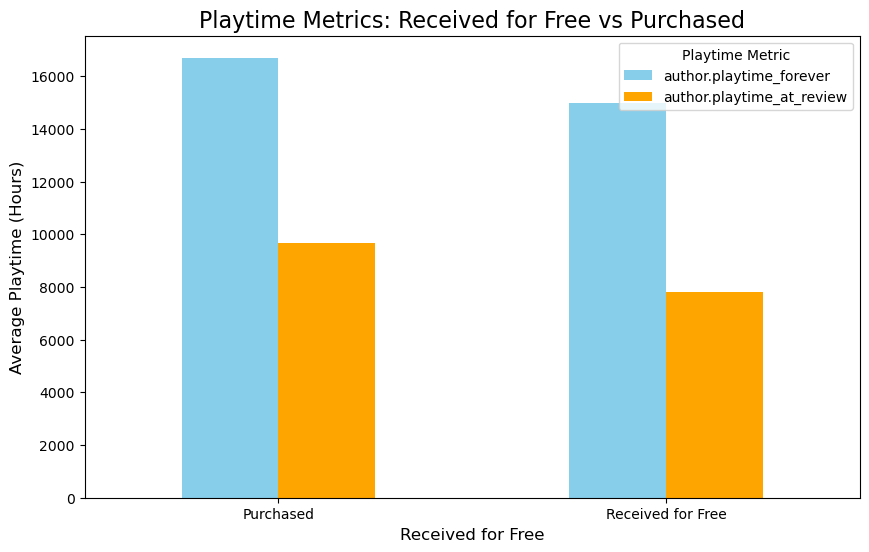

In [ ]:
#comparing average playtime for free vs purchased
playtime_metrics = df.groupby('received_for_free')[['author.playtime_forever', 'author.playtime_at_review']].mean()

#plotting playtime comparison
playtime_metrics.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'])
plt.title("Playtime Metrics: Received for Free vs Purchased", fontsize=16)
plt.xlabel("Received for Free", fontsize=12)
plt.ylabel("Average Playtime (Hours)", fontsize=12)
plt.xticks(ticks=[0, 1], labels=["Purchased", "Received for Free"], rotation=0)
plt.legend(title="Playtime Metric")
plt.show()


Conclusions: Boring and combat are the main keywords for a negative review. Most reviews happen during november winter break. So a Dev should make sure to update combat before the holidays and before 3pm on a weekday.


Reviews: Assumption: playtime is the positively correlated with helpfulness of a review